In [1]:
import string
import random
from random import randint
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw

# Dataset generation (given)

## Generate perfect images

In [2]:
# Run this command only once:

# makes the output folder /content/pictures/
!mkdir pictures

In [3]:
# Run this command only once

# Downloads the license plate template to /content/blank_plate.png
!gdown 1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v

Downloading...
From: https://drive.google.com/uc?id=1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v
To: /content/blank_plate.png
100% 144k/144k [00:00<00:00, 14.0MB/s]


In [4]:
path = "/content/"

NUMBER_OF_PLATES = 100

# Generate NUMBER_OF_PLATES with random values of the form CC NN (C: character
# N: number)

for i in range(0, NUMBER_OF_PLATES):

    # Pick two random letters
    plate_alpha = ""
    for _ in range(0, 2):
        plate_alpha += (random.choice(string.ascii_uppercase))

    # Pick two random numbers
    num = randint(0, 99)
    plate_num = "{:02d}".format(num)

    # Write plate to image
    blank_plate = cv2.imread(path+'blank_plate.png')

    # Convert into a PIL image (this is so we can use the monospaced fonts)
    blank_plate_pil = Image.fromarray(blank_plate)

    # Get a drawing context
    draw = ImageDraw.Draw(blank_plate_pil)
    monospace = ImageFont.truetype(font="/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf",
                                   size=165)
    draw.text(xy=(48, 75),
              text=plate_alpha + " " + plate_num,
              fill=(255,0,0), font=monospace)

    # Convert back to OpenCV image and save
    blank_plate = np.array(blank_plate_pil)

    # Write license plate to file
    cv2.imwrite(os.path.join(path + "pictures/",
                             "plate_{}{}.png".format(plate_alpha, plate_num)),
                             blank_plate)

## Download and uncompress test set

In [5]:
!gdown 18TBwgykqhpCoyn6Sf6lV_-MplhIP9R5d
!unzip /content/test_pictures.zip

Downloading...
From: https://drive.google.com/uc?id=18TBwgykqhpCoyn6Sf6lV_-MplhIP9R5d
To: /content/test_pictures.zip
100% 16.6M/16.6M [00:00<00:00, 61.3MB/s]
Archive:  /content/test_pictures.zip
   creating: test_pictures/
  inflating: test_pictures/plate_AR20.png  
  inflating: test_pictures/plate_AT48.png  
  inflating: test_pictures/plate_AX07.png  
  inflating: test_pictures/plate_BJ61.png  
  inflating: test_pictures/plate_BR26.png  
  inflating: test_pictures/plate_BR36.png  
  inflating: test_pictures/plate_BT43.png  
  inflating: test_pictures/plate_BY61.png  
  inflating: test_pictures/plate_CC68.png  
  inflating: test_pictures/plate_CS82.png  
  inflating: test_pictures/plate_CU90.png  
  inflating: test_pictures/plate_CV48.png  
  inflating: test_pictures/plate_CW47.png  
  inflating: test_pictures/plate_DY60.png  
  inflating: test_pictures/plate_EP68.png  
  inflating: test_pictures/plate_ER19.png  
  inflating: test_pictures/plate_ER61.png  
  inflating: test_pictures/pl

## Example of Data Generator

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

In [7]:
# Load image:
image_path = '/content/test_pictures/plate_AR20.png'
# Create an array with a single image (we need it for the iterator)
image_array = np.expand_dims(Image.open(image_path), 0)

In [8]:
datagen = ImageDataGenerator(rotation_range=3, zoom_range=0.01,
                             brightness_range=[0.4, 1.0])

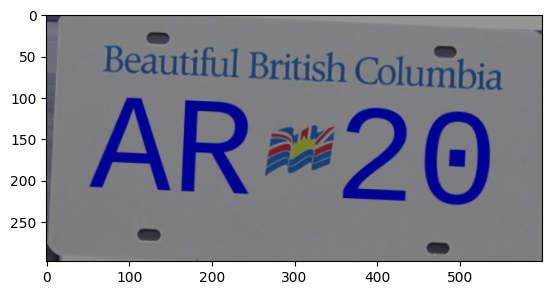

In [9]:
NUM_IMAGES_TO_GENERATE = 1

datagen_iterator = datagen.flow(image_array, batch_size=1)

for j in range(NUM_IMAGES_TO_GENERATE):
  value = next(datagen_iterator)
  img = value[0].astype('uint8')
  plt.imshow(img)

# Prepare dataset

In [10]:
# Create a mapping from each character to a number
character_set = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
character_mapping = {character: index for index, character in enumerate(character_set)}

In [11]:
## Splits the image into four equal columns, each representing a character.
# param input_image OpenCV image to split.
# return List of four images, each containing a split section.
def split_image(input_image):
    slice_width = input_image.shape[1] // 4  # width of each split section (integer for indexing)

    split_section1 = input_image[:, :slice_width]
    split_section2 = input_image[:, slice_width:2*slice_width]
    split_section3 = input_image[:, 2*slice_width:3*slice_width]
    split_section4 = input_image[:, 3*slice_width:]

    return [split_section1, split_section2, split_section3, split_section4]

In [12]:
## Creates a vector of one-hot-encoded vectors.
# Each one-hot vector has form [0 ... 0 1 0 ... 0] where the 1 falls
# at the target_index-th entry.
# param target_indices input numbers.
# param num_classes number of entries in each one-hot-encoded vector.
def generate_one_hot_vectors(target_indices, num_classes):
    one_hot_vectors = np.eye(num_classes)[target_indices.reshape(-1)]
    return one_hot_vectors

In [13]:
## Processes an input license plate and turns it into four input and output data points for training.
# param file_name Name of .png file to process.
# return List of four OpenCV images, each with one character.
# return List of four one-hot encoded vectors representing the characters in the corresponding images.
def process_license_plate(file_name):
    full_file_path = os.path.join(base_path, file_name)  # get full path to file
    input_image = cv2.imread(full_file_path)
    # make inputs
    input_slices = split_image(input_image)
    # make outputs
    character_sequence = file_name[-8:-4]
    output_indices = [character_mapping[character_sequence[0]], character_mapping[character_sequence[1]], character_mapping[character_sequence[2]], character_mapping[character_sequence[3]]]
    output_one_hot_vectors = generate_one_hot_vectors(np.array(output_indices), 36)
    return input_slices, output_one_hot_vectors

In [14]:
# Creating training dataset

# Base path for training images
training_images_path = "/content/pictures"

# Save image shape as Numpy array from the first image
image_shape = cv2.imread(os.path.join(training_images_path, os.listdir(training_images_path)[0])).shape

# Define empty arrays of the correct size
X_dataset = np.zeros((4 * TOTAL_PLATES, image_shape[0], image_shape[1] // 4, image_shape[2]))
Y_dataset = np.zeros((4 * TOTAL_PLATES, 36))

# Initialize counter for inserting into datasets
dataset_index = 0
for image_filename in os.listdir(training_images_path):  # Loop for every file in the folder
    input_slices, output_one_hot_vectors = process_license_plate(image_filename)
    for slice_index in range(4):  # Add each pair of inputs and outputs to the X and Y datasets
        X_dataset[dataset_index] = input_slices[slice_index]
        Y_dataset[dataset_index] = output_one_hot_vectors[slice_index]
        dataset_index += 1

# Create a tuple of the image shape for initializing the model
image_shape_tuple = (X_dataset[0].shape[0], X_dataset[0].shape[1], X_dataset[0].shape[2])



# Train CNN

In [15]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

## Reset Weights

In [16]:
## Reinitializes weights and biases of a Keras model
# param keras_model The Keras model to reset weights of
def reinitialize_model_weights(keras_model):
    for layer_index, layer in enumerate(keras_model.layers):  # loop for each layer of the model
        if (hasattr(keras_model.layers[layer_index], 'kernel_initializer') and
            hasattr(keras_model.layers[layer_index], 'bias_initializer')):  # only reset layers that actually have weights
            # get the weight and bias initializer from the model
            weight_initializer = keras_model.layers[layer_index].kernel_initializer
            bias_initializer = keras_model.layers[layer_index].bias_initializer

            # get the original weights and biases of the layer
            original_weights, original_biases = keras_model.layers[layer_index].get_weights()

            # reinitialize the weight and bias initializers with the same shape as original
            keras_model.layers[layer_index].set_weights([
                weight_initializer(shape=original_weights.shape),
                bias_initializer(shape=len(original_biases))])

## Model Definition

In [17]:
convolutional_model = models.Sequential()
convolutional_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                                      input_shape=image_shape_tuple))
convolutional_model.add(layers.MaxPooling2D((2, 2)))
convolutional_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
convolutional_model.add(layers.MaxPooling2D((2, 2)))
convolutional_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
convolutional_model.add(layers.MaxPooling2D((2, 2)))
convolutional_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
convolutional_model.add(layers.MaxPooling2D((2, 2)))
convolutional_model.add(layers.Flatten())
convolutional_model.add(layers.Dropout(0.5))
convolutional_model.add(layers.Dense(512, activation='relu'))
convolutional_model.add(layers.Dense(36, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
## Compile and train the convolutional neural network model
# Compile the model with appropriate loss function, optimizer, and metrics
convolutional_model.compile(optimizer='adam',
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

# Train the model using the training dataset
history = convolutional_model.fit(X_dataset, Y_dataset, epochs=10, batch_size=64, validation_split=0.2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 296, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 148, 74, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 146, 72, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 73, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 35, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 33, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 7, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14336)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14336)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       7,340,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 36)                  │          18,468 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,599,844 (28.99 MB)

 Trainable params: 7,599,844 (28.99 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
## Set the learning rate and compile the convolutional neural network model
LEARNING_RATE = 1e-4

# Compile the model with appropriate loss function, optimizer, and metrics
convolutional_model.compile(loss='categorical_crossentropy',
                            optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE),
                            metrics=['accuracy'])

In [20]:
reset_weights(conv_model)

In [21]:
validation_split_ratio = 0.2

training_history = convolutional_model.fit(X_dataset, Y_dataset,
                                           validation_split=validation_split_ratio,
                                           epochs=100,
                                           batch_size=16)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - acc: 0.0273 - loss: 40.0048 - val_acc: 0.3875 - val_loss: 2.3978
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - acc: 0.3332 - loss: 2.7733 - val_acc: 0.8375 - val_loss: 1.0584
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - acc: 0.7058 - loss: 1.2493 - val_acc: 0.9125 - val_loss: 0.5526
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - acc: 0.7679 - loss: 0.8428 - val_acc: 0.9125 - val_loss: 0.3445
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - acc: 0.8562 - loss: 0.5288 - val_acc: 0.9875 - val_loss: 0.0819
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - acc: 0.9170 - loss: 0.2720 - val_acc: 0.9500 - val_loss: 0.1865
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - acc: 0.9272 - loss: 0.2302 - val_acc: 0.9875 - val_loss: 0.0370
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - acc: 0.9700 - loss: 0.1248 - val_acc: 0.9125 - val_loss: 0.1737
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step 

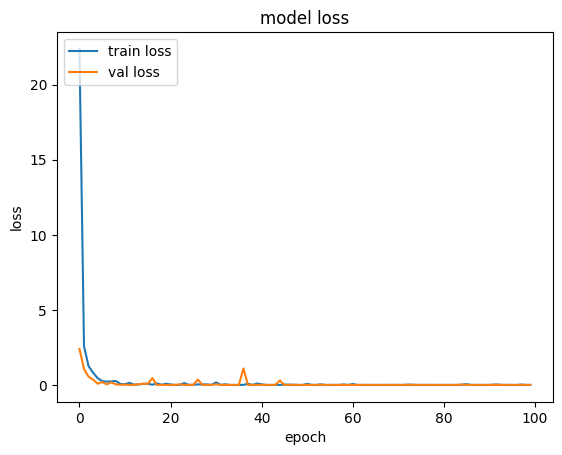

In [22]:
# Plot the training and validation loss over epochs
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

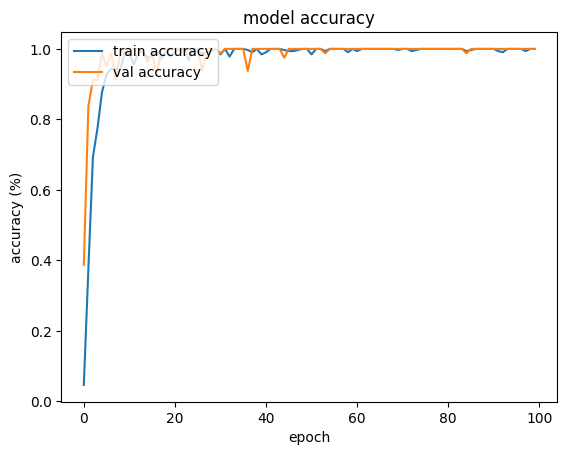

In [23]:
# Plot the training and validation accuracy over epochs
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Test the model

In [24]:
# Create test dataset

# Base path for test images
test_images_path = "/content/test_pictures"

# Initialize empty arrays for test dataset
X_test_dataset = np.zeros((4 * TOTAL_PLATES, image_shape[0], image_shape[1] // 4, image_shape[2]))
Y_test_dataset = np.zeros((4 * TOTAL_PLATES, 36))

# Initialize counter for inserting into test datasets
test_dataset_index = 0
for test_image_filename in os.listdir(test_images_path):
    test_input_slices, test_output_one_hot_vectors = process_license_plate(test_image_filename)
    for slice_index in range(4):
        X_test_dataset[test_dataset_index] = test_input_slices[slice_index]
        Y_test_dataset[test_dataset_index] = test_output_one_hot_vectors[slice_index]
        test_dataset_index += 1

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


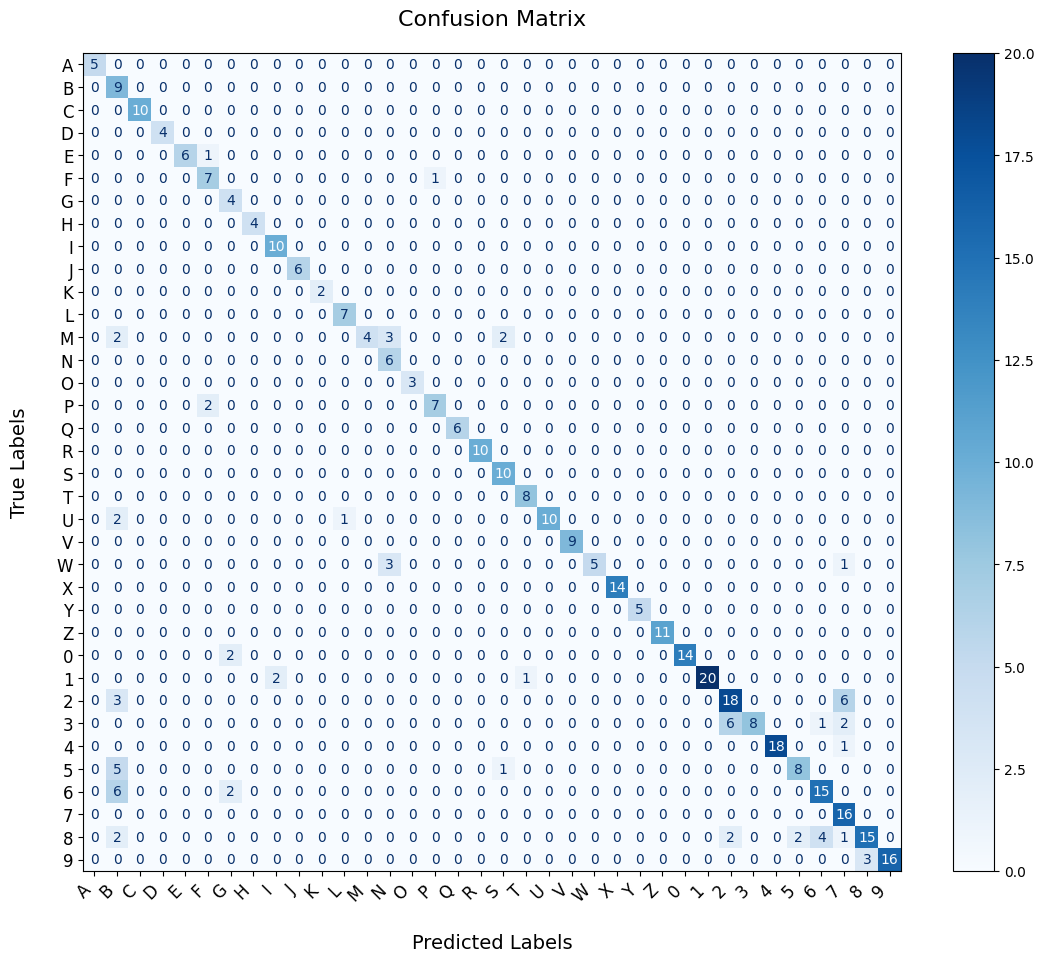

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Predict the labels for the test dataset
predicted_labels = convolutional_model.predict(X_test_dataset)
predicted_classes = np.argmax(predicted_labels, axis=1)

true_classes = np.argmax(Y_test_dataset, axis=1)

# Compute confusion matrix
confusion_matrix_result = confusion_matrix(true_classes, predicted_classes)

# Create labels for A-Z and 0-9
character_labels = [chr(i) for i in range(65, 91)] + [str(i) for i in range(10)]  # A-Z followed by 0-9

# Create confusion matrix display
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_result, display_labels=character_labels)

# Increase figure size
plt.figure(figsize=(12, 10))

# Plot with annotations and adjust spacing
confusion_matrix_display.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())

# Set title and axis labels with larger font size
plt.title("Confusion Matrix", fontsize=16, pad=20)  # Increased padding for title
plt.xlabel("Predicted Labels", fontsize=14, labelpad=20)  # Increased label padding
plt.ylabel("True Labels", fontsize=14, labelpad=20)  # Increased label padding

# Increase font size of ticks
plt.xticks(fontsize=12, rotation=45, ha='right')  # Rotate and align x ticks
plt.yticks(fontsize=12)

# Adjust layout for better spacing
plt.tight_layout(pad=3.0)  # Adjust overall padding

plt.show()